In [1]:
# 库文件
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
# 设置中文字体
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)  # 替换为你的中文字体文件路径


In [2]:
# 读取Excel文件
excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据处理\\趋势变量+噪声变量\\趋势变量加随机噪声-专用数据1.xlsx'
df_sheet = pd.read_excel(excel_path, sheet_name='建模-分量-全部') 
# excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据\\数据-时间戳.xlsx'
# df_sheet = pd.read_excel(excel_path, sheet_name='Sheet4') 
print(df_sheet.info())
print(df_sheet.columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7398 entries, 0 to 7397
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   时间戳          7398 non-null   float64
 1   铁口1温度        7398 non-null   float64
 2   时间戳.1        7398 non-null   float64
 3   P            7398 non-null   float64
 4   Unnamed: 4   0 non-null      float64
 5   时间戳.2        7398 non-null   float64
 6   SI           7398 non-null   float64
 7   Unnamed: 7   0 non-null      float64
 8   主参数时间戳       7398 non-null   float64
 9   冷风压力         7398 non-null   float64
 10  Unnamed: 10  0 non-null      float64
 11  Unnamed: 11  0 non-null      float64
 12  时间戳.3        7398 non-null   float64
 13  冷风流量         7398 non-null   float64
 14  Unnamed: 14  0 non-null      float64
 15  时间戳.4        7398 non-null   float64
 16  热风温度         7398 non-null   float64
 17  Unnamed: 17  0 non-null      float64
 18  时间戳.5        7398 non-null   float64
 19  设定喷煤量 

In [3]:
# 定义输入输出参数
input_term = ['冷风压力', '冷风流量', '热风温度', '设定喷煤量']
output_term = ['铁口1温度','SI']
time_term= '时间戳'


In [4]:
# 异常数据处理-处理前后对比
# 创建数据框副本以避免修改原始数据
df_sheet_process = df_sheet.copy()

# 定义一个函数，用中位数替换异常值
def replace_outliers_with_median(series):
    # 计算列的中位数
    median_value = series.median()
    # 检测异常值
    outliers = (series - median_value).abs() > 3.0 * series.std()  # 使用标准差作为阈值
    # 使用中位数替换异常值
    series[outliers] = median_value
# 画出数据
def plot_subplot(data_x,data_y_yuan,data_y,column):
    plt.plot(data_x,data_y_yuan,'r-')
    plt.plot(data_x,data_y,'m-')
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签
    # 使用中文标签


# 对指定列应用替代异常值的函数
# replace_outliers_with_median(df_sheet_process[input_term[0]])
# replace_outliers_with_median(df_sheet_process[input_term[1]])
# replace_outliers_with_median(df_sheet_process[output_term[0]])
# replace_outliers_with_median(df_sheet_process[output_term[1]])
# replace_outliers_with_median(df_sheet_process[output_term[2]])
# replace_outliers_with_median(df_sheet_process[output_term[3]])

# plt.figure(figsize=(15, 10))
# for idx, column in enumerate(input_term+output_term):
    
#     plt.subplot(len(input_term+output_term), 1, idx+1)
#     plot_subplot(df_sheet_process[time_term].values,df_sheet[column].values,df_sheet_process[column].values,column)




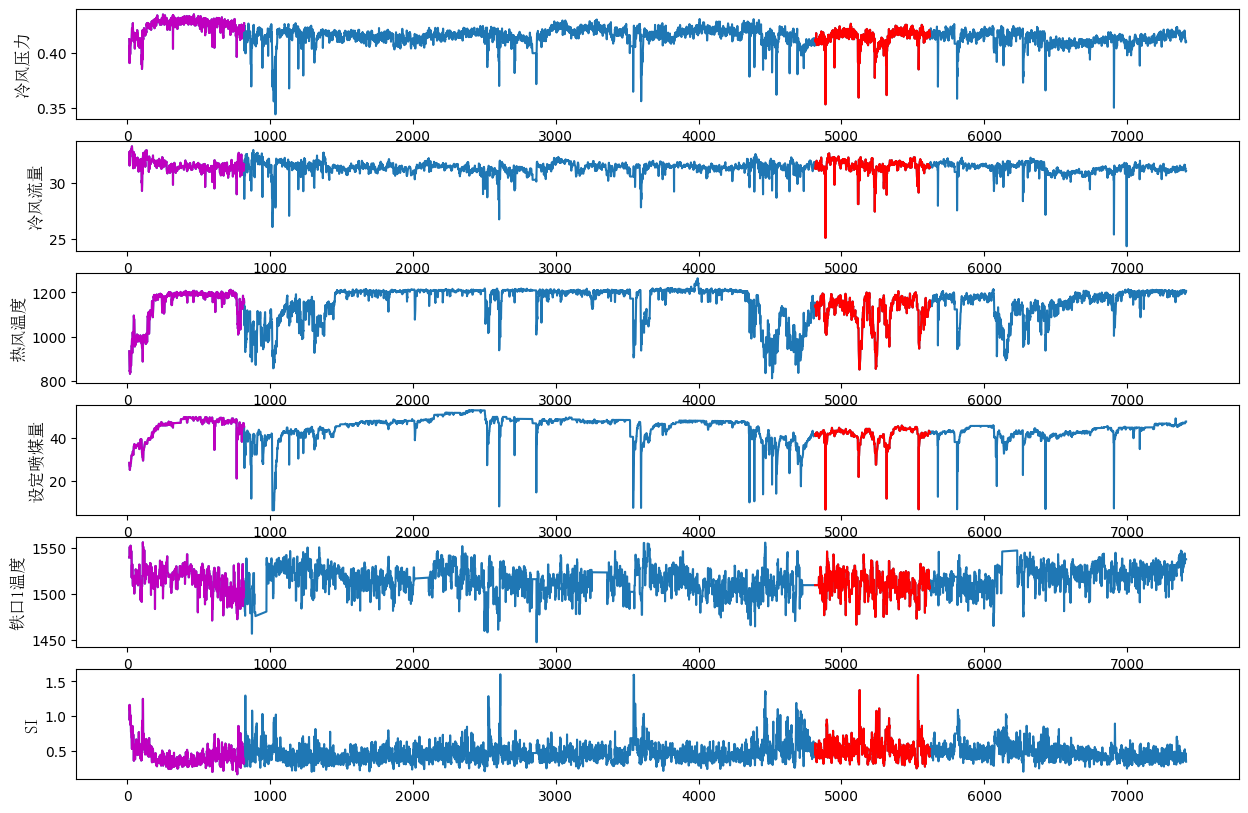

In [5]:
# 画出选取的数据
def plot_subplot(data_x,data_y,column,index_predict,index_gaolu):
    plt.plot(data_x,data_y,'-')
    plt.plot(data_x[index_gaolu],data_y[index_gaolu],'m-')
    plt.plot(data_x[index_predict],data_y[index_predict],'r-')
    
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签

length1 = 804
start1 = 0
length2 = 804
start2 = 4800


index_gaolu   = range(start1, start1+length1+1, 1)
index_predict     = range(start2, start2+length2+1, 1)
# index = range(1, 7572, 1)


plt.figure(figsize=(15, 10))
for idx, column in enumerate(input_term+output_term):
    plt.subplot(len(input_term+output_term), 1, idx+1)
    plot_subplot(df_sheet_process[time_term].values,df_sheet_process[column].values,column,index_predict,index_gaolu)


In [6]:
# 数据归一化、逆归一化
from sklearn.preprocessing import MinMaxScaler

# 将数据存储为字典，每个键对应一列数据
original_data_dict = {
    input_term[0]:   df_sheet[input_term[0]].values,
    input_term[1]:   df_sheet[input_term[1]].values,
    input_term[2]:   df_sheet[input_term[2]].values,
    input_term[3]:   df_sheet[input_term[3]].values,
    output_term[0]:  df_sheet[output_term[0]].values,
    output_term[1]:  df_sheet[output_term[1]].values
}

# 初始化缩放器
scalers = {}

# 进行拟合
for column, data in original_data_dict.items():
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(data.reshape(-1, 1))  # 保证数据是列向量
    scalers[column] = scaler

# 进行归一化
normalized_data_dict = {}
for column, scaler in scalers.items():
    normalized_data_dict[column] = scaler.transform(original_data_dict[column].reshape(-1, 1)).flatten()

# 进行反归一化
original_data_dict = {}
for column, scaler in scalers.items():
    original_data_dict[column] = scaler.inverse_transform(normalized_data_dict[column].reshape(-1, 1)).flatten()


In [7]:
# # 标定归一化前后数据
# data_point = np.array([1500]).reshape(-1, 1)
# data1 = scalers[output_term[0]].transform(data_point).flatten()

# data_point = np.array(data1).reshape(-1, 1)
# data2 = scalers[output_term[0]].inverse_transform(data_point).flatten()

# data_point = np.array([1510]).reshape(-1, 1)
# data3 = scalers[output_term[0]].transform(data_point).flatten()

# data_point = np.array(data3).reshape(-1, 1)
# data4 = scalers[output_term[0]].inverse_transform(data_point).flatten()

# print(data1)
# print(data2)
# print(data3)
# print(data4)
# print('每摄氏度的输出差：',(data3-data1)/(data4-data2))



# data_point = np.array([0.5]).reshape(-1, 1)
# data1 = scalers[output_term[1]].transform(data_point).flatten()

# data_point = np.array(data1).reshape(-1, 1)
# data2 = scalers[output_term[1]].inverse_transform(data_point).flatten()

# data_point = np.array([0.6]).reshape(-1, 1)
# data3 = scalers[output_term[1]].transform(data_point).flatten()

# data_point = np.array(data3).reshape(-1, 1)
# data4 = scalers[output_term[1]].inverse_transform(data_point).flatten()

# print(data1)
# print(data2)
# print(data3)
# print(data4)
# print('每0.01浓度的输出差：',(data3-data1))


In [45]:
isShuffle = True
# isShuffle = False


In [46]:
# 组合训练数据--拆分训练、测试集
train_size = 0.7
val_size = 0.15
test_size = 0.15
def make_data(u1_data,u2_data,u3_data,u4_data,y1_data,y2_data,test_size):
    # 假设您有六个时间序列数据
    # u1_data, u2_data, u3_data, u4_data, y1_data, y2_data 是形状为 (800, 1) 的 NumPy 数组

    # 堆叠输入和输出数据
    X = np.column_stack((u1_data, u2_data, u3_data, u4_data, y1_data, y2_data))
    y = np.column_stack((y1_data, y2_data))
    # print('X',X.shape)

    # 定义时间步数和特征数
    time_steps = 5
    features = 6

    # 创建空数组用于存储新的输入和输出数据
    X_modified = []
    y_modified = []
    
    # 生成新的输入和输出数据
    for i in range(len(X) - time_steps):
        X_sample = X[i:i + time_steps, :]
        y_sample = y[i + time_steps, :]  # 取每个序列的第11个时刻作为输出
        # print(i,i + time_steps,i + time_steps)
        X_modified.append(X_sample)
        y_modified.append(y_sample)

    # 将列表转换为 NumPy 数组
    X_modified = np.array(X_modified)
    y_modified = np.array(y_modified)

    # 打印新数据的形状
    print("Modified Input Shape:", X_modified.shape)
    print("Modified Output Shape:", y_modified.shape)



    X_train, X_test, y_train, y_test = train_test_split(X_modified, y_modified, 
                                                        test_size=test_size, 
                                                        random_state=42, 
                                                        shuffle=isShuffle)

    # 将剩余的70%训练数据再次拆分成训练数据和验证数据（20%验证数据，50%训练数据）
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                        test_size=val_size/(train_size+val_size), 
                                                        random_state=42, 
                                                        shuffle=isShuffle)

    print('训练数量：',X_train.shape,y_train.shape)
    print('验证数量：',X_val.shape,y_val.shape)
    print('测试数量：',X_test.shape,y_test.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test


In [47]:
# 高炉模型列数据
u1_data = normalized_data_dict[input_term[0]][index_gaolu]
u2_data = normalized_data_dict[input_term[1]][index_gaolu]
u3_data = normalized_data_dict[input_term[2]][index_gaolu]
u4_data = normalized_data_dict[input_term[3]][index_gaolu]
y1_data = normalized_data_dict[output_term[0]][index_gaolu]
y2_data = normalized_data_dict[output_term[1]][index_gaolu]
num_samples = y2_data.shape[0]

print('高炉模型数据')
X_gaolu_train, X_gaolu_val, X_gaolu_test,\
y_gaolu_train, y_gaolu_val, y_gaolu_test = make_data(u1_data,u2_data,u3_data,u4_data,
                                                            y1_data,y2_data,
                                                            test_size=test_size)



高炉模型数据
Modified Input Shape: (800, 5, 6)
Modified Output Shape: (800, 2)
训练数量： (559, 5, 6) (559, 2)
验证数量： (121, 5, 6) (121, 2)
测试数量： (120, 5, 6) (120, 2)


In [48]:
# 预测模型列数据
u1_data = normalized_data_dict[input_term[0]][index_predict]
u2_data = normalized_data_dict[input_term[1]][index_predict]
u3_data = normalized_data_dict[input_term[2]][index_predict]
u4_data = normalized_data_dict[input_term[3]][index_predict]
y1_data = normalized_data_dict[output_term[0]][index_predict]
y2_data = normalized_data_dict[output_term[1]][index_predict]
num_samples = y2_data.shape[0]


# print('Oxygen_enrich_rate:', u1_data.shape)
# print('Set_coal_amount:', u2_data.shape)
# print('hot_wind_temp:', u3_data.shape)
# print('hot_wind_presure:', u4_data.shape)
# print('temp:', y1_data.shape)
# print('Si_percent:', y2_data.shape)
# print(num_samples)

X_predict_train, X_predict_val, X_predict_test,\
y_predict_train, y_predict_val, y_predict_test = make_data(u1_data,u2_data,u3_data,u4_data,
                                                            y1_data,y2_data,
                                                            test_size=test_size)


Modified Input Shape: (800, 5, 6)
Modified Output Shape: (800, 2)
训练数量： (559, 5, 6) (559, 2)
验证数量： (121, 5, 6) (121, 2)
测试数量： (120, 5, 6) (120, 2)


In [49]:
# plt.plot(u1_data)
# plt.plot(u2_data)
# plt.plot(u3_data)
# plt.plot(u4_data)
# plt.plot(y1_data)
# plt.plot(y2_data)


In [50]:
# 定义LSTM模型
import torch
import torch.nn as nn
import torch.optim as optim

class MyRNNModel(torch.nn.Module):
    def __init__(self,features_size,hidden_size,isbidirectional):
        super(MyRNNModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=features_size,
            hidden_size=hidden_size,
            batch_first=True,
            bidirectional=isbidirectional
        )
        if isbidirectional:
            self.fc = nn.Linear(2 * hidden_size, 2)
        else:
            self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        
        last_lstm_output = lstm_out[:, -1, :]
        # print(last_lstm_output)
        output = self.fc(last_lstm_output)
        
        return output

    def custom_loss(self, y_true, y_pred):
        squared_diff = torch.pow(y_true - y_pred, 2)
        sum_squared_diff = torch.sum(squared_diff)
        mse = sum_squared_diff / len(y_true)
        return mse



    def my_fit(self, 
                X_train, y_train, 
                X_val, y_val, 
                train_loss_list,val_loss_list,
                epochs=1, batch_size=32, lr=0.001):
        optimizer = optim.Adam(self.parameters(), lr=lr)


        for epoch in range(epochs):
            epoch_loss = 0
            for i in range(0, len(X_train), batch_size):
                x_batch = torch.tensor(X_train[i:i+batch_size], dtype=torch.float32)
                y_batch = torch.tensor(y_train[i:i+batch_size], dtype=torch.float32)

                optimizer.zero_grad()
                y_pred = self(x_batch)
                loss = self.custom_loss(y_batch, y_pred)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            average_epoch_train_loss = epoch_loss / (len(X_train) / batch_size)
            # 验证集评估
            self.eval()
            with torch.no_grad():
                val_loss = 0
                for i in range(0, len(X_val), batch_size):
                    x_batch_val = torch.tensor(X_val[i:i+batch_size], dtype=torch.float32)
                    y_batch_val = torch.tensor(y_val[i:i+batch_size], dtype=torch.float32)

                    y_pred_val = self(x_batch_val)
                    val_loss += self.custom_loss(y_batch_val, y_pred_val).item()

                average_epoch_val_loss = val_loss / (len(X_train) / batch_size)

            print(f'第 {epoch + 1}/{epochs} 轮, 训练误差: {average_epoch_train_loss:.4f}, 验证误差: {average_epoch_val_loss:.4f}', end='\r')
            train_loss_list.append(average_epoch_train_loss)
            val_loss_list.append(average_epoch_val_loss)

        return train_loss_list,val_loss_list
    
    

    def my_predict(self, X_test):
        # 设置模型为评估模式，这会关闭 dropout 等层
        self.eval()
        # 将输入数据转换为张量，并设置 requires_grad=True
        x_tensor = torch.tensor(X_test, dtype=torch.float32, requires_grad=True)
        
        # 获取模型的预测输出
        y_pred = self(x_tensor)
        # 保留预测值的梯度信息
        y_pred.retain_grad()
        # 返回预测结果和包含梯度信息的张量
        return y_pred[:,0].detach().numpy(),y_pred[:,1].detach().numpy()


In [51]:
epoch_once_time = 200


In [52]:
# 建立高炉模型实例
features_size = 6
hidden_size = 16
# 设置随机种子
torch.manual_seed(0)
model_gaolu = MyRNNModel(features_size = features_size, 
                        hidden_size = hidden_size,
                        isbidirectional=False)
epoch_sum_gaolu = 0
gaolu_train_loss_list = []
gaolu_val_loss_list = []



第 200/200 轮, 训练误差: 0.0293, 验证误差: 0.0054
epoch_sum: 200


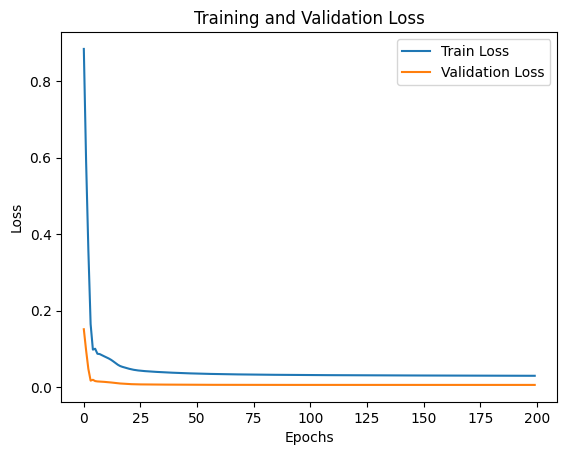

In [53]:
# 高炉模型训练
epoch_once = epoch_once_time
epoch_sum_gaolu = epoch_sum_gaolu + epoch_once
gaolu_train_loss_list,gaolu_val_loss_list = model_gaolu.my_fit(X_gaolu_train, y_gaolu_train,
                                    X_gaolu_val, y_gaolu_val, 
                                    gaolu_train_loss_list, gaolu_val_loss_list,
                                    epochs=epoch_once, 
                                    batch_size=64,
                                    lr = 0.002)

print('\nepoch_sum:',epoch_sum_gaolu)

# 绘制训练和验证损失曲线
plt.plot(gaolu_train_loss_list, label='Train Loss')
plt.plot(gaolu_val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


RMSE:  铁口1温度: 7.0617 , SI: 0.0681 
MAPE:  铁口1温度: 0.2961% , SI: 11.4008%
MRE :  铁口1温度: 0.0030  , SI: 0.1140 


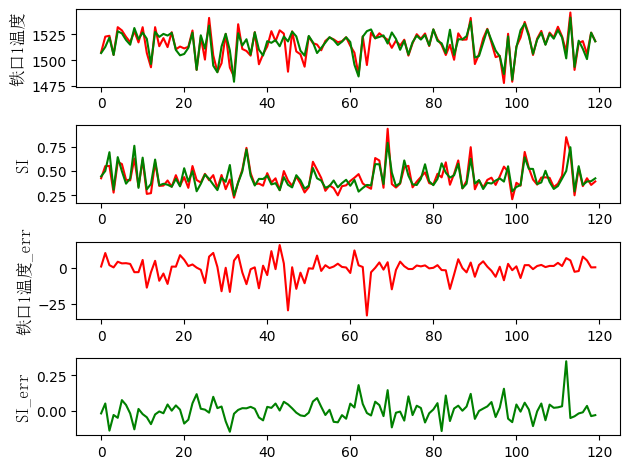

In [54]:
# 高炉模型预测
y_pred_0,y_pred_1  = model_gaolu.my_predict(X_gaolu_test)
# 计算 RMSE、MRE
y_test = y_gaolu_test




y_test_0 = scalers[output_term[0]].inverse_transform((y_test[:, 0]).reshape(-1, 1)).flatten()
y_test_1 = scalers[output_term[1]].inverse_transform((y_test[:, 1]).reshape(-1, 1)).flatten()
y_pred_0_inverse_transform = scalers[output_term[0]].inverse_transform((y_pred_0).reshape(-1, 1)).flatten()
y_pred_1_inverse_transform = scalers[output_term[1]].inverse_transform((y_pred_1).reshape(-1, 1)).flatten()

rmse_0 = np.sqrt(mean_squared_error(y_test_0, y_pred_0_inverse_transform))
rmse_1 = np.sqrt(mean_squared_error(y_test_1, y_pred_1_inverse_transform))

# 计算 
mre_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0))
mre_1 = np.mean(np.abs((y_test_1 - y_pred_1_inverse_transform) / y_test_1))


mape_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0)) * 100
mape_1 = np.mean(np.abs((y_test_1 - y_pred_1_inverse_transform) / y_test_1)) * 100

# 打印结果

print(f"RMSE:  {output_term[0]}: {rmse_0:.4f} , {output_term[1]}: {rmse_1:.4f} ")
print(f"MAPE:  {output_term[0]}: {mape_0:.4f}% , {output_term[1]}: {mape_1:.4f}%")
print(f"MRE :  {output_term[0]}: { mre_0:.4f}  , {output_term[1]}: { mre_1:.4f} ")

# plot_hit_rate_curve(y_test, y_pred_0, y_pred_1)


output0 = y_test_0 - y_pred_0_inverse_transform
output1 = y_test_1 - y_pred_1_inverse_transform

# print(f"误差分析0:平均值:{output0.std():.4f},方差:{output0.mean():.4f}")
# print(f"误差分析1:平均值:{output1.std():.4f},方差:{output1.mean():.4f}")


plt.subplot(4, 1, 1)
plt.plot(y_test_0,'r')
plt.plot(y_pred_0_inverse_transform,'g')
plt.ylabel(output_term[0], fontproperties=font)  # 使用中文标签


plt.subplot(4, 1, 2)
plt.plot(y_test_1,'r')
plt.plot(y_pred_1_inverse_transform,'g')
plt.ylabel(output_term[1], fontproperties=font)  # 使用中文标签
#

plt.subplot(4, 1, 3)
plt.plot(output0,'r-')
plt.ylabel(output_term[0]+'_err', fontproperties=font)  # 使用中文标签


plt.subplot(4, 1, 4)
plt.plot(output1,'g-')
plt.ylabel(output_term[1]+'_err', fontproperties=font)  # 使用中文标签


plt.tight_layout()
plt.show()



In [55]:
# 创建预测模型实例
features_size = 6
hidden_size_predict = 16
# 设置随机种子
torch.manual_seed(0)
model = MyRNNModel(features_size = features_size, 
                    hidden_size = hidden_size_predict,
                    isbidirectional=True)
epoch_sum_predict = 0
predict_train_loss_list = []
predict_val_loss_list = []



第 200/200 轮, 训练误差: 0.0404, 验证误差: 0.0075
epoch_sum: 0


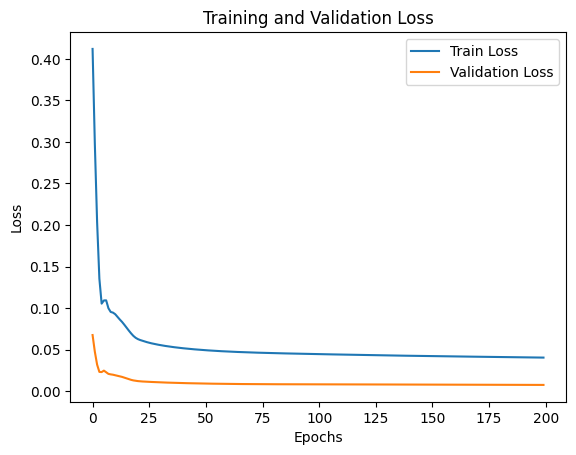

In [56]:
# 预测模型训练
epoch_once = epoch_once_time
epoch_sum = epoch_sum_predict + epoch_once
predict_train_loss_list, predict_val_loss_list = model.my_fit(X_predict_train, y_predict_train,
                                    X_predict_val, y_predict_val, 
                                    predict_train_loss_list, predict_val_loss_list,
                                    epochs=epoch_once, 
                                    batch_size=128,
                                    lr = 0.002)

print('\nepoch_sum:',epoch_sum_predict)


# 绘制训练和验证损失曲线
plt.plot(predict_train_loss_list, label='Train Loss')
plt.plot(predict_val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


RMSE:  铁口1温度: 8.4658 , SI: 0.1253 
MAPE:  铁口1温度: 0.3938% , SI: 12.7924%
MRE :  铁口1温度: 0.0039  , SI: 0.1279 


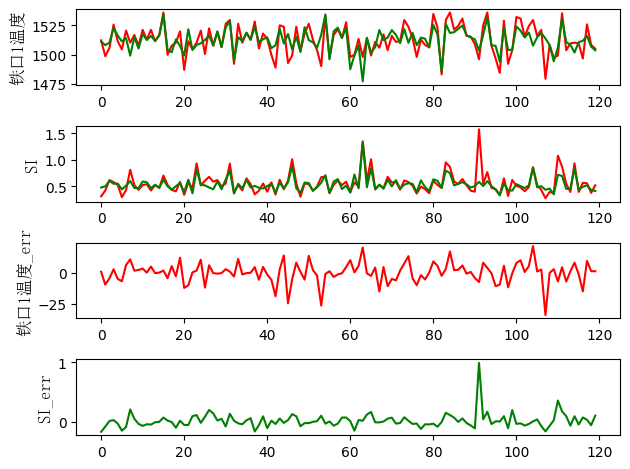

In [57]:
# 预测模型预测
y_pred_0,y_pred_1  = model.my_predict(X_predict_test)

# 计算 RMSE、MRE
y_test = y_predict_test
# y_test = y_test[:-1]
# y_pred_0 = y_pred_0[1:]
# y_pred_1 = y_pred_1[1:]


y_test_0 = scalers[output_term[0]].inverse_transform((y_test[:, 0]).reshape(-1, 1)).flatten()
y_test_1 = scalers[output_term[1]].inverse_transform((y_test[:, 1]).reshape(-1, 1)).flatten()
y_pred_0_inverse_transform = scalers[output_term[0]].inverse_transform((y_pred_0).reshape(-1, 1)).flatten()
y_pred_1_inverse_transform = scalers[output_term[1]].inverse_transform((y_pred_1).reshape(-1, 1)).flatten()

rmse_0 = np.sqrt(mean_squared_error(y_test_0, y_pred_0_inverse_transform))
rmse_1 = np.sqrt(mean_squared_error(y_test_1, y_pred_1_inverse_transform))

# 计算 
mre_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0))
mre_1 = np.mean(np.abs((y_test_1 - y_pred_1_inverse_transform) / y_test_1))


mape_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0)) * 100
mape_1 = np.mean(np.abs((y_test_1 - y_pred_1_inverse_transform) / y_test_1)) * 100

# 打印结果
print(f"RMSE:  {output_term[0]}: {rmse_0:.4f} , {output_term[1]}: {rmse_1:.4f} ")
print(f"MAPE:  {output_term[0]}: {mape_0:.4f}% , {output_term[1]}: {mape_1:.4f}%")
print(f"MRE :  {output_term[0]}: { mre_0:.4f}  , {output_term[1]}: { mre_1:.4f} ")

# plot_hit_rate_curve(y_test, y_pred_0, y_pred_1)


output0 = y_test_0 - y_pred_0_inverse_transform
output1 = y_test_1 - y_pred_1_inverse_transform

# print(f"误差分析0:平均值:{output0.std():.4f},方差:{output0.mean():.4f}")
# print(f"误差分析1:平均值:{output1.std():.4f},方差:{output1.mean():.4f}")


plt.subplot(4, 1, 1)
plt.plot(y_test_0,'r')
plt.plot(y_pred_0_inverse_transform,'g')
plt.ylabel(output_term[0], fontproperties=font)  # 使用中文标签


plt.subplot(4, 1, 2)
plt.plot(y_test_1,'r')
plt.plot(y_pred_1_inverse_transform,'g')
plt.ylabel(output_term[1], fontproperties=font)  # 使用中文标签
#

plt.subplot(4, 1, 3)
plt.plot(output0,'r-')
plt.ylabel(output_term[0]+'_err', fontproperties=font)  # 使用中文标签


plt.subplot(4, 1, 4)
plt.plot(output1,'g-')
plt.ylabel(output_term[1]+'_err', fontproperties=font)  # 使用中文标签


plt.tight_layout()
plt.show()


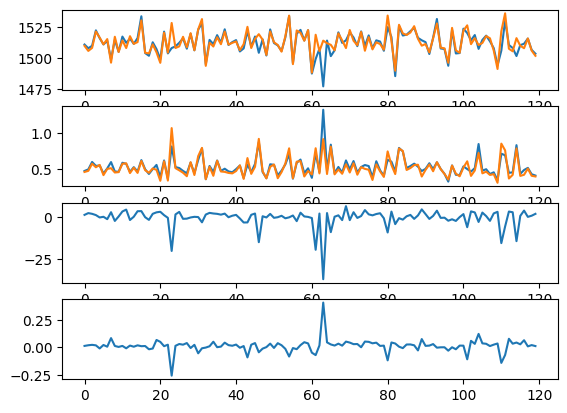

In [58]:
y_pred_0,y_pred_1  = model.my_predict(X_predict_test)
y_pred_0_predict = scalers[output_term[0]].inverse_transform((y_pred_0).reshape(-1, 1)).flatten()
y_pred_1_predict = scalers[output_term[1]].inverse_transform((y_pred_1).reshape(-1, 1)).flatten()

y_pred_0,y_pred_1  = model_gaolu.my_predict(X_predict_test)
y_pred_0_gaolu = scalers[output_term[0]].inverse_transform((y_pred_0).reshape(-1, 1)).flatten()
y_pred_1_gaolu = scalers[output_term[1]].inverse_transform((y_pred_1).reshape(-1, 1)).flatten()

plt.subplot(4, 1, 1)
plt.plot(y_pred_0_predict)
plt.plot(y_pred_0_gaolu)

plt.subplot(4, 1, 2)
plt.plot(y_pred_1_predict)
plt.plot(y_pred_1_gaolu)

plt.subplot(4, 1, 3)
plt.plot(y_pred_0_predict-y_pred_0_gaolu)

plt.subplot(4, 1, 4)
plt.plot(y_pred_1_predict-y_pred_1_gaolu)

